In [1]:
import pandas as pd
from loader import get_gas_price_per_block, get_swap_data_per_block
from joblib import Parallel, delayed
from metrics import sharpe, max_drawdown
from strategy import run_backtest_onpercent
import matplotlib.pyplot as plt

In [2]:
gas_price = get_gas_price_per_block(eth_path='./data/eth_price.csv', gas_path='./data/gas_price.csv')

/home/ubuntu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
range_percentages = [10*i for i in range(1,6, 2)]
move_percentages = [5*i for i in range(1,4)]

In [4]:
def compute(range_percentages, move_percentages):
    for range_percentage in range_percentages:
        for move_percentage in move_percentages:
            yield(range_percentage, move_percentage)

In [9]:
swap_path = './data/eth_price.csv'

out = Parallel(n_jobs=18, verbose=True)(delayed(run_backtest_onpercent)
                (amount_invested = 1e5,swap_path=swap_path, gas_price=gas_price,disable_costs=False,
                decimal_diff=12, swap_cost=13e-3, range_percent=range_percentage, move_percent=move_percentage)
                for range_percentage, move_percentage in compute(range_percentages, move_percentages))

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  12 out of  15 | elapsed:  1.7min remaining:   25.7s
[Parallel(n_jobs=18)]: Done  15 out of  15 | elapsed:  1.7min finished


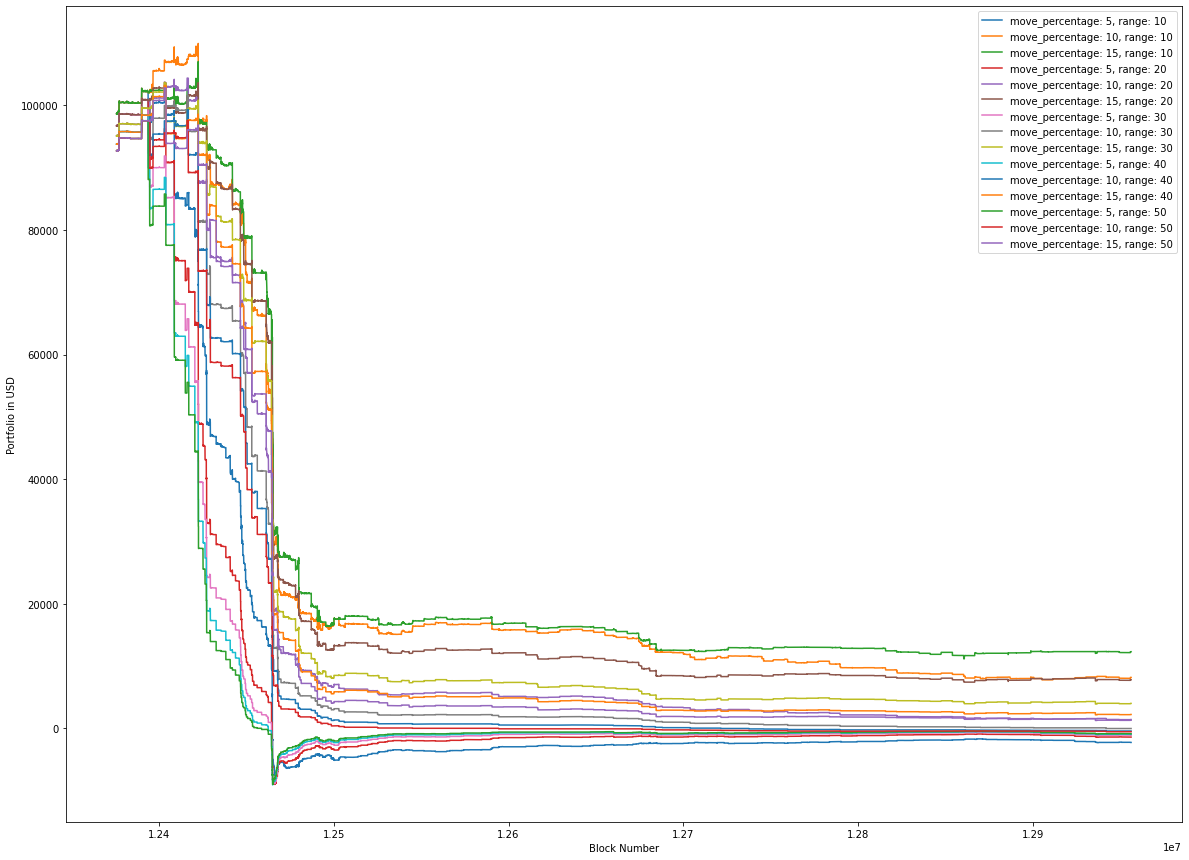

In [12]:
for i in range(len(out)):
    out[i]['holdings']['usd'].plot(figsize=(20, 15))
L = plt.legend(loc='upper right')
count = 0
for i in range(len(out)):
    L.get_texts()[count].set_text(f'move_percentage: {out[i]["move_percent"]}, range: {out[i]["range_percent"]}')
    count+=1
plt.xlabel('Block Number')
plt.ylabel('Portfolio in USD')
plt.show()

In [5]:
swap_path = './data/eth_price_july.csv'

out = Parallel(n_jobs=18, verbose=True)(delayed(run_backtest_onpercent)
                (amount_invested = 1e5,swap_path=swap_path, gas_price=gas_price,disable_costs=True,
                decimal_diff=12, swap_cost=0, range_percent=range_percentage, move_percent=move_percentage)
                for range_percentage, move_percentage in compute(range_percentages, move_percentages))

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   4 out of   9 | elapsed:   16.0s remaining:   20.1s
[Parallel(n_jobs=18)]: Done   9 out of   9 | elapsed:   16.2s finished


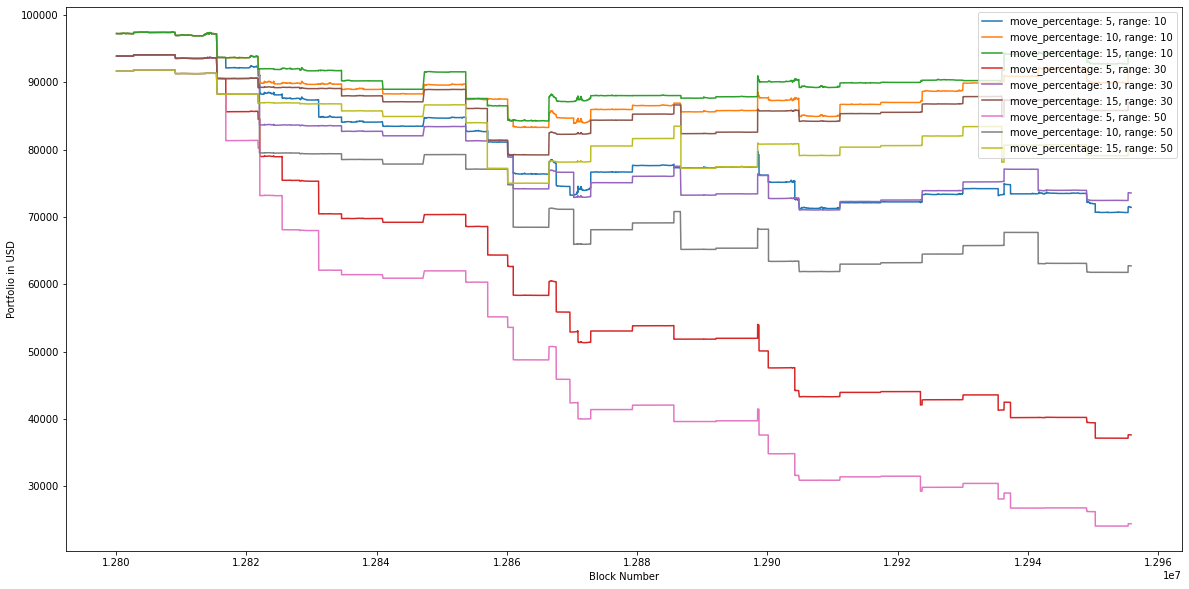

In [6]:
for i in range(len(out)):
    out[i]['holdings']['usd'].plot(figsize=(20, 10))
L = plt.legend(loc='upper right')
count = 0
for i in range(len(out)):
    L.get_texts()[count].set_text(f'move_percentage: {out[i]["move_percent"]}, range: {out[i]["range_percent"]}')
    count+=1
plt.xlabel('Block Number')
plt.ylabel('Portfolio in USD')
plt.show()

In [39]:
a = pd.read_csv('./data/eth_price.csv')
a[a.BLOCK_ID >12800000].to_csv('./data/eth_price_july.csv', index=False)

/home/ubuntu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Text(0, 0.5, 'Portfolio in USD')

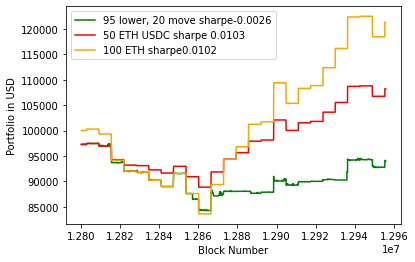

In [7]:
swap_data = get_swap_data_per_block(swap_path)
for i in range(len(out)):
    if out[i]['range_percent']==10 and out[i]['move_percent']==15:
        out[i]['holdings']['usd'].plot(color='green')
        holdings = out[i]['holdings']
        hold_portfolio_5050 = (holdings.reserve0.iloc[0]*swap_data['token0_price']) + (holdings.reserve1.iloc[0]*swap_data['token1_price'])
        hold_portfolio_5050.plot(color='red')
        holdings_eth = (1e5/swap_data.token1_price.iloc[0])*swap_data['token1_price']
        holdings_eth.plot(color='orange')
        sharpe_holdings = sharpe(holdings.usd.pct_change().dropna())
        sharpe_hold_port = sharpe(hold_portfolio_5050.pct_change().dropna())
        sharpe_hold_eth = sharpe(holdings_eth.pct_change().dropna())
        plt.legend([f'95 lower, 20 move sharpe{round(sharpe_holdings,4)}', 
                    f'50 ETH USDC sharpe {round(sharpe_hold_port,4)}',
                    f'100 ETH sharpe{round(sharpe_hold_eth, 4)}' ])
plt.xlabel('Block Number')
plt.ylabel('Portfolio in USD')

In [8]:
holdings.head()

,rebalance,usd,fees,gas_cost,swap_cost,percentage_tick,return_on_swap,fee_usd,reserve0,reserve1,ub,lb,cp,fee_amount0,fee_amount1
12800091,0.0,97273.337458,0.0,0.0,0.0,0.001227,0.0,0.0,46015.861229,24.158373,0.000000,0.000000,0.000000,1.119454,0.000000
12800099,0.0,97271.645431,0.0,0.0,0.0,0.001227,0.0,0.0,46188.906475,24.075999,0.000524,0.000428,0.000476,0.102345,0.000000
12800103,0.0,97271.645431,0.0,0.0,0.0,0.001227,0.0,0.0,46188.906475,24.075999,0.000524,0.000428,0.000476,0.007359,0.000000
12800110,0.0,97271.645431,0.0,0.0,0.0,0.001226,0.0,0.0,46188.906475,24.075999,0.000524,0.000428,0.000476,0.000751,0.000000
12800112,0.0,97271.645431,0.0,0.0,0.0,0.001232,0.0,0.0,46188.906475,24.075999,0.000524,0.000428,0.000476,0.000000,0.000001


In [10]:
holdings.fee_amount0

12800091    1.119454
12800099    0.102345
12800103    0.007359
12800110    0.000751
12800112    0.000000
              ...   
12955822    0.685647
12955830    1.228033
12955847    0.000000
12955848    0.000000
12955850    0.000000
Name: fee_amount0, Length: 12502, dtype: float64